# Homework 3: Prediction and Classification

Due: Thursday, October 16, 2014 11:59 PM

<a href=https://raw.githubusercontent.com/cs109/2014/master/homework/HW3.ipynb download=HW3.ipynb> Download this assignment</a>

#### Submission Instructions
To submit your homework, create a folder named lastname_firstinitial_hw# and place your IPython notebooks, data files, and any other files in this folder. Your IPython Notebooks should be completely executed with the results visible in the notebook. We should not have to run any code. Compress the folder (please use .zip compression) and submit to the CS109 dropbox in the appropriate folder. If we cannot access your work because these directions are not followed correctly, we will not grade your work.

---


# Introduction

In this assignment you will be using regression and classification to explore different data sets.  

**First**: You will use data from before 2002 in the [Sean Lahman's Baseball Database](http://seanlahman.com/baseball-archive/statistics) to create a metric for picking baseball players using linear regression. This is same database we used in Homework 1. This database contains the "complete batting and pitching statistics from 1871 to 2013, plus fielding statistics, standings, team stats, managerial records, post-season data, and more". [Documentation provided here](http://seanlahman.com/files/database/readme2012.txt).

!["Sabermetrics Science"](http://saberseminar.com/wp-content/uploads/2012/01/saber-web.jpg)
http://saberseminar.com/wp-content/uploads/2012/01/saber-web.jpg

**Second**: You will use the famous [iris](http://en.wikipedia.org/wiki/Iris_flower_data_set) data set to perform a $k$-neareast neighbor classification using cross validation.  While it was introduced in 1936, it is still [one of the most popular](http://archive.ics.uci.edu/ml/) example data sets in the machine learning community. Wikipedia describes the data set as follows: "The data set consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimetres." Here is an illustration what the four features measure:

!["iris data features"](http://sebastianraschka.com/Images/2014_python_lda/iris_petal_sepal.png)
http://sebastianraschka.com/Images/2014_python_lda/iris_petal_sepal.png

**Third**: You will investigate the influence of higher dimensional spaces on the classification using another standard data set in machine learning called the The [digits data set](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html).  This data set is similar to the MNIST data set discussed in the lecture. The main difference is, that each digit is represented by an 8x8 pixel image patch, which is considerably smaller than the 28x28 pixels from MNIST. In addition, the gray values are restricted to 16 different values (4 bit), instead of 256 (8 bit) for MNIST. 

**Finally**: In preparation for Homework 4, we want you to read through the following articles related to predicting the 2014 Senate Midterm Elections. 

* [Nate Silver's Methodology at while at NYT](http://fivethirtyeight.blogs.nytimes.com/methodology/)
* [How The FiveThirtyEight Senate Forecast Model Works](http://fivethirtyeight.com/features/how-the-fivethirtyeight-senate-forecast-model-works/)
* [Pollster Ratings v4.0: Methodology](http://fivethirtyeight.com/features/pollster-ratings-v40-methodology/)
* [Pollster Ratings v4.0: Results](http://fivethirtyeight.com/features/pollster-ratings-v40-results/)
* [Nate Silver versus Sam Wang](http://www.washingtonpost.com/blogs/plum-line/wp/2014/09/17/nate-silver-versus-sam-wang/)
* [More Nate Silver versus Sam Wang](http://www.dailykos.com/story/2014/09/09/1328288/-Get-Ready-To-Rumbllllle-Battle-Of-The-Nerds-Nate-Silver-VS-Sam-Wang)
* [Nate Silver explains critisims of Sam Wang](http://politicalwire.com/archives/2014/10/02/nate_silver_rebuts_sam_wang.html)
* [Background on the feud between Nate Silver and Sam Wang](http://talkingpointsmemo.com/dc/nate-silver-sam-wang-feud)
* [Are there swing voters?]( http://www.stat.columbia.edu/~gelman/research/unpublished/swing_voters.pdf)



---

## Load Python modules

In [2]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

import requests 
import StringIO
import zipfile
import numpy as np
import pandas as pd # pandas
import matplotlib.pyplot as plt # module for plotting 

# If this module is not already installed, you may need to install it. 
# You can do this by typing 'pip install seaborn' in the command line
#import seaborn as sns 

import sklearn
import sklearn.datasets
import sklearn.cross_validation
import sklearn.decomposition
import sklearn.grid_search
import sklearn.neighbors
import sklearn.metrics


c:\python27\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
c:\python27\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# Problem 1: Sabermetrics

Using data preceding the 2002 season pick 10 offensive players keeping the payroll under $20 million (assign each player the median salary). Predict how many games this team would win in a 162 game season.  

In this problem we will be returning to the [Sean Lahman's Baseball Database](http://seanlahman.com/baseball-archive/statistics) that we used in Homework 1.  From this database, we will be extract five data sets containing information such as yearly stats and standing, batting statistics, fielding statistics, player names, player salaries and biographical information. You will explore the data in this database from before 2002 and create a metric for picking players. 

#### Problem 1(a) 

Load in [these CSV files](http://seanlahman.com/files/database/lahman-csv_2014-02-14.zip) from the [Sean Lahman's Baseball Database](http://seanlahman.com/baseball-archive/statistics). For this assignment, we will use the 'Teams.csv', 'Batting.csv', 'Salaries.csv', 'Fielding.csv', 'Master.csv' tables. Read these tables into separate pandas DataFrames with the following names. 

CSV file name | Name of pandas DataFrame
:---: | :---: 
Teams.csv | teams
Batting.csv | players
Salaries.csv | salaries
Fielding.csv | fielding
Master.csv | master

In [3]:
url = "http://seanlahman.com/files/database/lahman-csv_2014-02-14.zip"
source = requests.get(url)
r=source.content
s = StringIO.StringIO(r)
zf = zipfile.ZipFile(s, 'r')

In [4]:
teams=pd.read_csv(zf.open("Teams.csv"))
players=pd.read_csv(zf.open("Batting.csv"))
salaries=pd.read_csv(zf.open("Salaries.csv"))
fielding=pd.read_csv(zf.open("Fielding.csv"))
master=pd.read_csv(zf.open("Master.csv"))

#### Problem 1(b)

Calculate the median salary for each player and create a pandas DataFrame called `medianSalaries` with four columns: (1) the player ID, (2) the first name of the player, (3) the last name of the player and (4) the median salary of the player. Show the head of the `medianSalaries` DataFrame.   

In [5]:
medianSalaries=master[["playerID","nameFirst","nameLast"]]
def f(name):
    salaries_av=salaries["salary"][salaries["playerID"]==name].median()
    return salaries_av
medianSalaries.loc[:,"medianSal"]=[f(i) for i in medianSalaries["playerID"]]

c:\python27\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
c:\python27\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [6]:
medianSalaries.head()


,playerID,nameFirst,nameLast,medianSal
0,aardsda01,David,Aardsma,419000.0
1,aaronha01,Hank,Aaron,NaN
2,aaronto01,Tommie,Aaron,NaN
3,aasedo01,Don,Aase,612500.0
4,abadan01,Andy,Abad,327000.0


#### Problem 1(c)

Now, consider only team/season combinations in which the teams played 162 Games. Exclude all data from before 1947. Compute the per plate appearance rates for singles, doubles, triples, HR, and BB. Create a new pandas DataFrame called `stats` that has the teamID, yearID, wins and these rates.

**Hint**: Singles are hits that are not doubles, triples, nor HR. Plate appearances are base on balls plus at bats.

In [7]:
teams_new=teams[(teams["yearID"]>=1947) & (teams["G"]==162)]

In [8]:
teams_new.loc[:,"PA"]=teams_new["AB"]+teams_new["BB"]
teams_new.loc[:,"Singles"]=(teams_new["H"]-teams_new["2B"]-teams_new["3B"]-teams_new["HR"])/teams_new["PA"]
teams_new.loc[:,"Doubles"]=(teams_new["2B"])/teams_new["PA"]
teams_new.loc[:,"Triples"]=(teams_new["3B"])/teams_new["PA"]
teams_new.loc[:,"Homerun"]=(teams_new["HR"])/teams_new["PA"]
teams_new.loc[:,"Base on balls"]=(teams_new["BB"])/teams_new["PA"]

In [9]:
stats=teams_new[["teamID","yearID","W","PA","Singles","Doubles","Triples","Homerun","Base on balls"]];
stats.head()


,teamID,yearID,W,PA,Singles,Doubles,Triples,Homerun,Base on balls
1366,LAA,1961,70,6105,0.147748,0.035708,0.003604,0.030958,0.111548
1367,KC1,1961,61,6003,0.164751,0.035982,0.007829,0.014993,0.096618
1377,NYA,1962,96,6228,0.167148,0.038536,0.004656,0.031952,0.093770
1379,LAA,1962,86,6101,0.159482,0.038027,0.005737,0.022455,0.098672
1381,CHA,1962,85,6134,0.165797,0.040756,0.009129,0.014998,0.101076


#### Problem 1(d)

Is there a noticeable time trend in the rates computed computed in Problem 1(c)? 

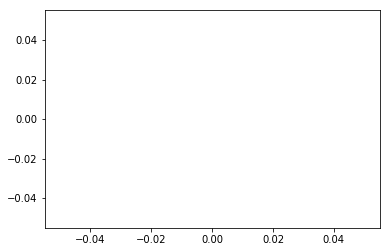

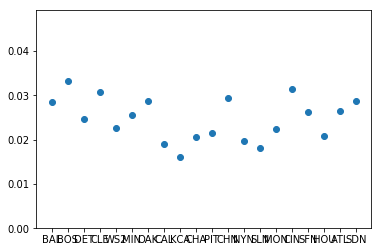

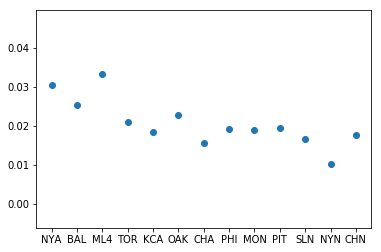

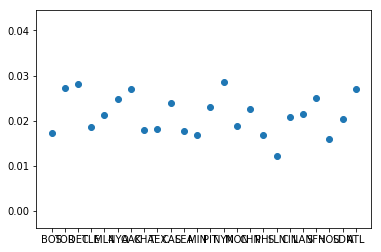

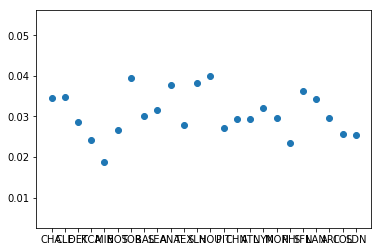

In [10]:
year=np.arange(1960,2010,10)
for y in year:
    stats_new=stats[stats["yearID"]==y]
    plt.scatter(stats_new["teamID"],stats_new["Homerun"])
    plt.show()


### Trend
The trend is that the amount of doubles and homeruns increases over time. 

#### Problem 1(e) 

Using the `stats` DataFrame from Problem 1(c), adjust the singles per PA rates so that the average across teams for each year is 0. Do the same for the doubles, triples, HR, and BB rates. 

In [11]:
years=stats["yearID"].unique();
stats2=stats.copy()

In [12]:
for y in years:
    stats_new=stats[stats["yearID"]==y]
    av_singles=stats_new["Singles"].mean()
    av_doubles=stats_new["Doubles"].mean()
    av_triples=stats_new["Triples"].mean()
    av_homerun=stats_new["Homerun"].mean()
    av_bb=stats_new["Base on balls"].mean()
    stats2["Singles"][stats2["yearID"]==y]=stats2["Singles"][stats2["yearID"]==y]-av_singles
    stats2["Doubles"][stats2["yearID"]==y]=stats2["Doubles"][stats2["yearID"]==y]-av_doubles
    stats2["Triples"][stats2["yearID"]==y]=stats2["Triples"][stats2["yearID"]==y]-av_triples
    stats2["Homerun"][stats2["yearID"]==y]=stats2["Homerun"][stats2["yearID"]==y]-av_homerun
    stats2["Base on balls"][stats2["yearID"]==y]=stats2["Base on balls"][stats2["yearID"]==y]-av_bb
    
    

c:\python27\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\python27\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
c:\python27\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
c:\python27\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be s

In [13]:
stats=stats2;
stats.head()

,teamID,yearID,W,PA,Singles,Doubles,Triples,Homerun,Base on balls
1366,LAA,1961,70,6105,-0.008502,-0.000137,-0.002113,0.007983,0.007465
1367,KC1,1961,61,6003,0.008502,0.000137,0.002113,-0.007983,-0.007465
1377,NYA,1962,96,6228,0.001516,0.002683,-0.002121,0.008141,0.005180
1379,LAA,1962,86,6101,-0.006150,0.002174,-0.001040,-0.001356,0.010082
1381,CHA,1962,85,6134,0.000165,0.004904,0.002352,-0.008813,0.012486


#### Problem 1(f)

Build a simple linear regression model to predict the number of wins from the average adjusted singles, double, triples, HR, and BB rates. To decide which of these terms to include fit the model to data from 2002 and compute the average squared residuals from predictions to years past 2002. Use the fitted model to define a new sabermetric summary: offensive predicted wins (OPW). Hint: the new summary should be a linear combination of one to five of the five rates.


In [14]:
reg=sklearn.linear_model.LinearRegression()
x_train=stats[["Singles","Doubles","Homerun","Base on balls"]].loc[stats["yearID"]==2002,:]
y_train=stats["W"].loc[stats["yearID"]==2002]
x_test=stats[["Singles","Doubles","Homerun","Base on balls"]].loc[stats["yearID"]==2003,:]
y_test=stats["W"].loc[stats["yearID"]==2003]
reg.fit(x_train,y_train)
pred=reg.predict(x_train)
print sklearn.metrics.mean_squared_error(y_train,pred)
pred2=reg.predict(x_test)
print sklearn.metrics.mean_squared_error(y_test,pred2)
coef=reg.coef_
print coef
intercept=reg.intercept_
print intercept



79.3406028085
125.298561252
[  952.22539391  1346.40726273  1185.84132101   697.69691762]
81.3636363636


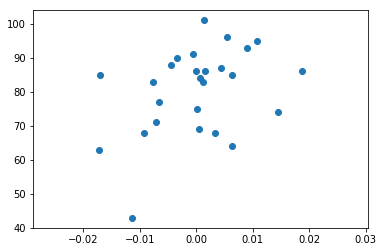

In [15]:
plt.scatter(x_test["Base on balls"],y_test)

** Your answer here: **
The OPW must be a linear combination of the features except triples because they correlate not very well. 

#### Problem 1(g)

Now we will create a similar database for individual players. Consider only player/year combinations in which the player had at least 500 plate appearances. Consider only the years we considered for the calculations above (after 1947 and seasons with 162 games). For each player/year compute singles, doubles, triples, HR, BB per plate appearance rates. Create a new pandas DataFrame called `playerstats` that has the playerID, yearID and the rates of these stats.  Remove the average for each year as for these rates as done in Problem 1(e). 

Show the head of the `playerstats` DataFrame. 

In [16]:
players2=players.copy()
players2.loc[:,"PA"]=players2.loc[:,"AB"]+players2.loc[:,"BB"]

In [17]:
def f(x):
    if x[1] in teams["yearID"][teams["G"]==162].unique():
        
        if x[3] in teams["teamID"][(teams["G"]==162)&(teams["yearID"]==x[1])].unique():
            return True   
        else:
            return False
    else: 
        return False 

In [18]:
players2["Games162"]=players2.apply(f,axis=1)
players2=players2[players2["Games162"]==True]

In [26]:
players2.loc[:,"Singles"]=(players2["H"]-players2["2B"]-players2["3B"]-players2["HR"])/players2["PA"]
players2.loc[:,"Doubles"]=(players2["2B"])/players2["PA"]
players2.loc[:,"Triples"]=(players2["3B"])/players2["PA"]
players2.loc[:,"Homerun"]=(players2["HR"])/players2["PA"]
players2.loc[:,"Base on balls"]=(players2["BB"])/players2["PA"]

In [28]:
playerstats=players2[["playerID","yearID","Singles","Doubles","Triples","Homerun","Base on balls","PA"]]
playerstats.head()

,playerID,yearID,Singles,Doubles,Triples,Homerun,Base on balls,PA
0,aardsda01,2004,NaN,NaN,NaN,NaN,NaN,0.0
1,aardsda01,2006,0.0,0.0,0.0,0.0,0.0,2.0
2,aardsda01,2007,NaN,NaN,NaN,NaN,NaN,0.0
3,aardsda01,2008,0.0,0.0,0.0,0.0,0.0,1.0
4,aardsda01,2009,NaN,NaN,NaN,NaN,NaN,0.0


#### Problem 1(h)

Using the `playerstats` DataFrame created in Problem 1(g), create a new DataFrame called `playerLS` containing the player's lifetime stats. This DataFrame should contain the playerID, the year the player's career started, the year the player's career ended and the player's lifetime average for each of the quantities (singles, doubles, triples, HR, BB). For simplicity we will simply compute the avaerage of the rates by year (a more correct way is to go back to the totals). 

In [ ]:
playerLS=pd.DataFrame()
playerLS["playerID"]=playerstats["playerID"].unique()
playerLS["startYear"]=map(g,playerLS["playerID"])
playerLS["endYear"]=map(h,playerLS["playerID"])
playerLS["avSingle"]=map(lambda x: playerstats["Singles"][playerstats["playerID"]==x].mean(),playerLS["playerID"])
playerLS["avDoubles"]=map(lambda x: playerstats["Doubles"][playerstats["playerID"]==x].mean(),playerLS["playerID"])
playerLS["avTriples"]=map(lambda x: playerstats["Triples"][playerstats["playerID"]==x].mean(),playerLS["playerID"])
playerLS["avHomerun"]=map(lambda x: playerstats["Homerun"][playerstats["playerID"]==x].mean(),playerLS["playerID"])
playerLS["avBase on balls"]=map(lambda x: playerstats["Base on balls"][playerstats["playerID"]==x].mean(),playerLS["playerID"])

In [ ]:
def g(name):
    temp=playerstats["yearID"][playerstats["playerID"]==name]
    return temp.min()
def h(name):
    temp=playerstats["yearID"][playerstats["playerID"]==name]
    return temp.max()

Show the head of the `playerLS` DataFrame. 

In [ ]:
playerLS.head()

#### Problem 1(i)

Compute the OPW for each player based on the average rates in the `playerLS` DataFrame. You can interpret this summary statistic as the predicted wins for a team with 9 batters exactly like the player in question. Add this column to the playerLS DataFrame. Call this colum OPW.

In [ ]:
playerLS["OPW"]=playerLS.apply(lambda x: (sum(x[3:8]*coef4))+intercept,axis=1)

In [ ]:
playerLS.head()

In [ ]:
coef=reg.coef_
intercept=reg.intercept_
coef3=np.append(coef[0:2],0,)
coef4=np.append(coef3,coef[2:5])


#### Problem 1(j)

Add four columns to the `playerLS` DataFrame that contains the player's position (C, 1B, 2B, 3B, SS, LF, CF, RF, or OF), first name, last name and median salary. 

In [ ]:
master.columns
#players.columns
#fielding.columns
salaries.columns

In [232]:
#fielding[fielding["playerID"]=="ansonca01"]

In [ ]:
playerLS["Position"]=[fielding["POS"][fielding["playerID"]==name].iloc[0]   for name in playerLS["playerID"]]
playerLS["FirstName"]=[master["nameFirst"][master["playerID"]==name].iloc[0] for name in playerLS["playerID"]]
playerLS["LastName"]=[master["nameLast"][master["playerID"]==name].iloc[0] for name in playerLS["playerID"]]

In [ ]:
playerLS["medianSalaries"]=[medianSalaries["medianSal"][medianSalaries["playerID"]==name].iloc[0] for name in playerLS["playerID"]]

Show the head of the `playerLS` DataFrame. 

In [ ]:
playerLS.head()

#### Problem 1(k)

Subset the `playerLS` DataFrame for players active in 2002 and 2003 and played at least three years. Plot and describe the relationship bewteen the median salary (in millions) and the predicted number of wins. 

In [ ]:
playerLS2=playerLS[(playerLS["startYear"]<2002)&(playerLS["endYear"]>=2003)&(playerLS["endYear"]-playerLS["startYear"]>=3)]

In [ ]:
plt.scatter(playerLS2["medianSalaries"],playerLS2["OPW"])

In [ ]:
playerLS2.head()

#### Problem 1(l)
Pick one players from one of each of these 10 position C, 1B, 2B, 3B, SS, LF, CF, RF, DH, or OF keeping the total median salary of all 10 players below 20 million. Report their averaged predicted wins and total salary.

In [ ]:
playerLS2[(playerLS2["medianSalaries"]<4000000)&(playerLS2["OPW"]>440)]

In [20]:
My_awesome_team=["nevinph01","sweenmi01"]
team_df=pd.DataFrame()
#for name in My_awesome_team:
team_df.append(playerLS2[playerLS2["playerID"] == "nevinph01"])

NameError: name 'playerLS2' is not defined

In [284]:
playerLS2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119 entries, 1 to 1203
Data columns (total 13 columns):
playerID           119 non-null object
startYear          119 non-null int64
endYear            119 non-null int64
avSingle           119 non-null float64
avDoubles          119 non-null float64
avTriples          119 non-null float64
avHomerun          119 non-null float64
avBase on balls    119 non-null float64
OPW                119 non-null float64
Position           119 non-null object
FirstName          119 non-null object
LastName           119 non-null object
medianSalaries     119 non-null float64
dtypes: float64(7), int64(2), object(4)
memory usage: 15.2+ KB


In [287]:
team_df

""


In [288]:
for name in My_awesome_team:
    print name

nevinph01
sweenmi01


In [278]:
playerLS2[playerLS2["playerID"] == "nevinph01"]

,playerID,startYear,endYear,avSingle,avDoubles,avTriples,avHomerun,avBase on balls,OPW,Position,FirstName,LastName,medianSalaries
823,nevinph01,2000,2004,0.159861,0.052588,0.001102,0.053597,0.107189,449.092051,3B,Phil,Nevin,1250000.0


#### Problem 1(m)
What do these players outperform in? Singles, doubles, triples HR or BB?

In [ ]:
### Your code here ###

** Your answer here: **

## Discussion for Problem 1

*Write a brief discussion of your conclusions to the questions and tasks above in 100 words or less.*

---

# Problem 2:  $k$-Nearest Neighbors and Cross Validation 

What is the optimal $k$ for predicting species using $k$-nearest neighbor classification 
on the four features provided by the iris dataset.

In this problem you will get to know the famous iris data set, and use cross validation to select the optimal $k$ for a $k$-nearest neighbor classification. This problem set makes heavy use of the [sklearn](http://scikit-learn.org/stable/) library. In addition to Pandas, it is one of the most useful libraries for data scientists! After completing this homework assignment you will know all the basics to get started with your own machine learning projects in sklearn. 

Future lectures will give further background information on different classifiers and their specific strengths and weaknesses, but when you have the basics for sklearn down, changing the classifier will boil down to exchanging one to two lines of code.

The data set is so popular, that sklearn provides an extra function to load it:

In [ ]:
#load the iris data set
iris = sklearn.datasets.load_iris()

X = iris.data  
Y = iris.target

print X.shape, Y.shape

#### Problem 2(a) 
Split the data into a train and a test set. Use a random selection of 33% of the samples as test data. Sklearn provides the [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html) function for this purpose. Print the dimensions of all the train and test data sets you have created. 

In [ ]:
### Your code here ###

#### Problem 2(b)

Examine the data further by looking at the projections to the first two principal components of the data. Use the [`TruncatedSVD`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) function for this purpose, and create a scatter plot. Use the colors on the scatter plot to represent the different classes in the target data. 

In [ ]:
### Your code here ###

#### Problem 2(c) 

In the lecture we discussed how to use cross validation to estimate the optimal value for $k$ (the number of nearest neighbors to base the classification on). Use ***ten fold cross validation*** to estimate the optimal value for $k$ for the iris data set. 

**Note**: For your convenience sklearn does not only include the [KNN classifier](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html), but also a [grid search function](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html#sklearn.grid_search.GridSearchCV). The function is called grid search, because if you have to optimize more than one parameter, it is common practice to define a range of possible values for each parameter. An exhaustive search then runs over the complete grid defined by all the possible parameter combinations. This can get very computation heavy, but luckily our KNN classifier only requires tuning of a single parameter for this problem set. 

In [ ]:
### Your code here ###

#### Problem 2(d)

Visualize the result by plotting the score results versus values for $k$. 

In [ ]:
### Your code here ###

Verify that the grid search has indeed chosen the right parameter value for $k$.

In [ ]:
### Your code here ###

#### Problem 2(e)

Test the performance of our tuned KNN classifier on the test set.

In [ ]:
### Your code here ###

## Discussion for Problem 2

*Write a brief discussion of your conclusions to the questions and tasks above in 100 words or less.*

---

# Problem 3: The Curse and Blessing of Higher Dimensions

In this problem we will investigate the influence of higher dimensional spaces on the classification. The data set is again one of the standard data sets from sklearn. The [digits data set](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) is similar to the MNIST data set discussed in the lecture. The main difference is, that each digit is represented by an 8x8 pixel image patch, which is considerably smaller than the 28x28 pixels from MNIST. In addition, the gray values are restricted to 16 different values (4 bit), instead of 256 (8 bit) for MNIST. 

First we again load our data set.

In [ ]:
digits = sklearn.datasets.load_digits()

X = digits.data  
Y = digits.target

print X.shape, Y.shape

#### Problem 3(a) 

Start with the same steps as in Problem 2. Split the data into train and test set. Use 33% of the samples as test data. Print the dimensions of all the train and test data sets you created. 

In [ ]:
### Your code here ###

#### Problem 3(b) 

Similar to Problem 2(b), create a scatter plot of the projections to the first two PCs.  Use the colors on the scatter plot to represent the different classes in the target data. How well can we separate the classes?

**Hint**: Use a `Colormap` in matplotlib to represent the diferent classes in the target data. 

In [ ]:
### Your code here ###

Create individual scatter plots using only two classes at a time to explore which classes are most difficult to distinguish in terms of class separability.  You do not need to create scatter plots for all pairwise comparisons, but at least show one. 

In [ ]:
### Your code here ###

Give a brief interpretation of the scatter plot. Which classes look like hard to distinguish? Do both feature dimensions contribute to the class separability? 

** Your answer here: **

#### Problem 3(c) 

Write a **ten-fold cross validation** to estimate the optimal value for $k$ for the digits data set. *However*, this time we are interested in the influence of the number of dimensions we project the data down as well. 

Extend the cross validation as done for the iris data set, to optimize $k$ for different dimensional projections of the data. Create a boxplot showing test scores for the optimal $k$ for each $d$-dimensional subspace with $d$ ranging from one to ten. The plot should have the scores on the y-axis and the different dimensions $d$ on the x-axis. You can use your favorite plot function for the boxplots. [Seaborn](http://web.stanford.edu/~mwaskom/software/seaborn/index.html) is worth having a look at though. It is a great library for statistical visualization and of course also comes with a [`boxplot`](http://web.stanford.edu/~mwaskom/software/seaborn/generated/seaborn.boxplot.html) function that has simple means for changing the labels on the x-axis.

In [ ]:
### Your cross validation and evaluation code here ###

In [ ]:
### Your boxplot code here ### 

Write a short interpretation of the generated plot, answering the following questions:

* What trend do you see in the plot for increasing dimensions?

* Why do you think this is happening?

** Your answer here: **

#### Problem 3(d) 

**For AC209 Students**: Change the boxplot we generated above to also show the optimal value for $k$ chosen by the cross validation grid search. 

In [ ]:
### Your code here ### 

Write a short interpretation answering the following questions:

* Which trend do you observe for the optimal value of $k$?

* Why do you think this is happening?

** Your answer here: **

## Discussion for Problem 3

*Write a brief discussion of your conclusions to the questions and tasks above in 100 words or less.*

---

# Submission Instructions

To submit your homework, create a folder named **lastname_firstinitial_hw#** and place your IPython notebooks, data files, and any other files in this folder. Your IPython Notebooks should be completely executed with the results visible in the notebook. We should not have to run any code.  Compress the folder (please use .zip compression) and submit to the CS109 dropbox in the appropriate folder. *If we cannot access your work because these directions are not followed correctly, we will not grade your work.*
